# Himalayan Expedition Success Prediction 
### Problem Statement:
Predict whether an expedition will succeed or fail using historical expedition data.
We will analyze Himalayan climbing expeditions to understand factors that contribute to the success of an expedition. This analysis can help climbers and expedition planners make informed decisions to increase the likelihood of a successful climb.
### The real-world significance:

* Helps climbers assess risks.
* Assists expedition planners in improving success rates.
* Identifies key factors influencing success.

### About the dataset:
The dataset consists of three main tables:


1. expeditions.csv: Contains information about each expedition.
2. peaks.csv: Contains information about the peaks.
3. members.csv: Contains information about the members of each expedition.


In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [69]:
# Load datasets
df_expeditions = pd.read_csv('/kaggle/input/himalayan-climbing-expeditions/expeditions.csv')
df_peaks = pd.read_csv('/kaggle/input/himalayan-climbing-expeditions/peaks.csv')
df_members = pd.read_csv('/kaggle/input/himalayan-climbing-expeditions/members.csv')

In [70]:
# Merge datasets
df = df_expeditions.merge(df_peaks, on='peak_id')
df = df.merge(df_members, on='expedition_id')

column_names = df.columns.tolist()
print(column_names)

['expedition_id', 'peak_id_x', 'peak_name_x', 'year_x', 'season_x', 'basecamp_date', 'highpoint_date', 'termination_date', 'termination_reason', 'highpoint_metres_x', 'members', 'member_deaths', 'hired_staff', 'hired_staff_deaths', 'oxygen_used_x', 'trekking_agency', 'peak_name_y', 'peak_alternative_name', 'height_metres', 'climbing_status', 'first_ascent_year', 'first_ascent_country', 'first_ascent_expedition_id', 'member_id', 'peak_id_y', 'peak_name', 'year_y', 'season_y', 'sex', 'age', 'citizenship', 'expedition_role', 'hired', 'highpoint_metres_y', 'success', 'solo', 'oxygen_used_y', 'died', 'death_cause', 'death_height_metres', 'injured', 'injury_type', 'injury_height_metres']


## Initial Data Exploration
### Key steps:
#### 1. Remove redundant columns
#### 2. Handle missing values
#### 3. Analyze data distributions
#### 4. Investigate feature correlations

In [71]:
# Drop columns with irrelevant columns
drop_cols = ['expedition_id','peak_id_x', 'peak_name_x', 'termination_date', 'highpoint_metres_x', 'member_deaths', 
             'peak_name_y', 'peak_alternative_name', 'climbing_status', 'first_ascent_country', 'first_ascent_year', 'first_ascent_expedition_id',
             'member_id', 'peak_id_y','year_y', 'season_y','hired','highpoint_metres_y','oxygen_used_y', 'died','death_cause','death_height_metres', 'injured','injury_type',
             'injury_height_metres','hired_staff_deaths']
              
df.drop(columns=drop_cols, inplace=True)

# REname columns with suffixes
new_column_names = {
    'year_x': 'year',
    'season_x': 'season',
    'oxygen_used_x': 'oxygen_used'
}

# Rename columns
df.rename(columns=new_column_names, inplace=True)
df.head()

,year,season,basecamp_date,highpoint_date,termination_reason,members,hired_staff,oxygen_used,trekking_agency,height_metres,peak_name,sex,age,citizenship,expedition_role,success,solo
0,1960,Spring,1960-03-15,1960-05-17,Success (main peak),10,9,True,NaN,7937,Annapurna II,M,43.0,UK,Leader,False,False
1,1960,Spring,1960-03-15,1960-05-17,Success (main peak),10,9,True,NaN,7937,Annapurna II,M,32.0,UK,Climber,True,False
2,1960,Spring,1960-03-15,1960-05-17,Success (main peak),10,9,True,NaN,7937,Annapurna II,M,27.0,UK,Climber,False,False
3,1960,Spring,1960-03-15,1960-05-17,Success (main peak),10,9,True,NaN,7937,Annapurna II,M,30.0,UK,Climber,False,False
4,1960,Spring,1960-03-15,1960-05-17,Success (main peak),10,9,True,NaN,7937,Annapurna II,M,25.0,UK,Climber,True,False


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76511 entries, 0 to 76510
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                76511 non-null  int64  
 1   season              76511 non-null  object 
 2   basecamp_date       70541 non-null  object 
 3   highpoint_date      73850 non-null  object 
 4   termination_reason  76511 non-null  object 
 5   members             76511 non-null  int64  
 6   hired_staff         76511 non-null  int64  
 7   oxygen_used         76511 non-null  bool   
 8   trekking_agency     62165 non-null  object 
 9   height_metres       76511 non-null  int64  
 10  peak_name           76511 non-null  object 
 11  sex                 76509 non-null  object 
 12  age                 73014 non-null  float64
 13  citizenship         76501 non-null  object 
 14  expedition_role     76490 non-null  object 
 15  success             76511 non-null  bool   
 16  solo

In [73]:
df.describe()

,year,members,hired_staff,height_metres,age
count,76511.000000,76511.000000,76511.000000,76511.000000,73014.000000
mean,2000.362079,10.404465,5.978487,7924.003346,37.335936
std,14.793771,8.716421,9.552756,843.576690,10.394460
min,1905.000000,0.000000,0.000000,5407.000000,7.000000
25%,1991.000000,5.000000,1.000000,7135.000000,29.000000
50%,2004.000000,8.000000,3.000000,8167.000000,36.000000
75%,2012.000000,13.000000,7.000000,8850.000000,44.000000
max,2019.000000,99.000000,99.000000,8850.000000,85.000000


In [74]:
print(df.isna().sum().sort_values())

year                      0
season                    0
members                   0
termination_reason        0
hired_staff               0
oxygen_used               0
peak_name                 0
height_metres             0
success                   0
solo                      0
sex                       2
citizenship              10
expedition_role          21
highpoint_date         2661
age                    3497
basecamp_date          5970
trekking_agency       14346
dtype: int64


In [75]:
# Handle missing values using mean for numerical and most frequent for categorical
num_cols = df.select_dtypes(include=['number']).columns
cat_cols = df.select_dtypes(include=['object']).columns

df[num_cols] = df[num_cols].fillna(df[num_cols].median())  # Impute numerical
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])  # Impute categorical

In [76]:
print(df.isna().sum().sort_values())

year                  0
season                0
basecamp_date         0
highpoint_date        0
termination_reason    0
members               0
hired_staff           0
oxygen_used           0
trekking_agency       0
height_metres         0
peak_name             0
sex                   0
age                   0
citizenship           0
expedition_role       0
success               0
solo                  0
dtype: int64


### EDA

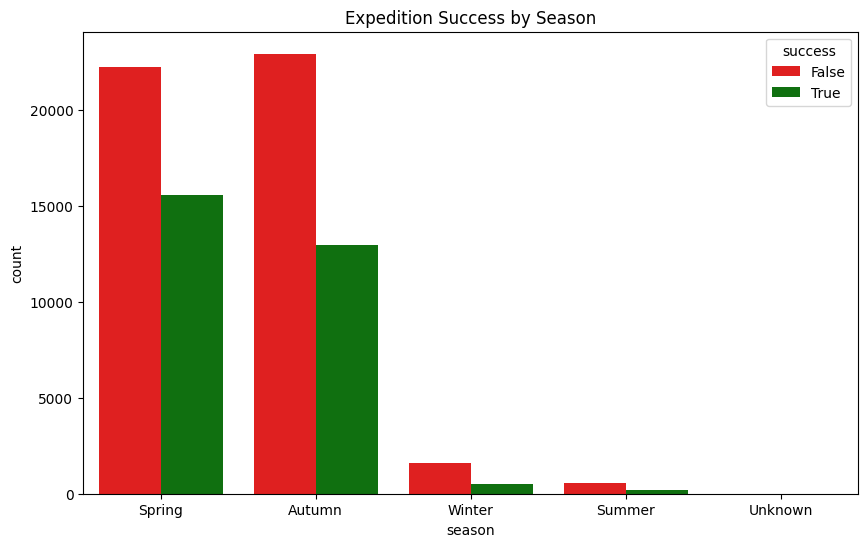

In [77]:
plt.figure(figsize=(10,6))
sns.countplot(x='season', hue='success', data=df, palette={True: 'green', False: 'red'})
plt.title('Expedition Success by Season')
plt.show()


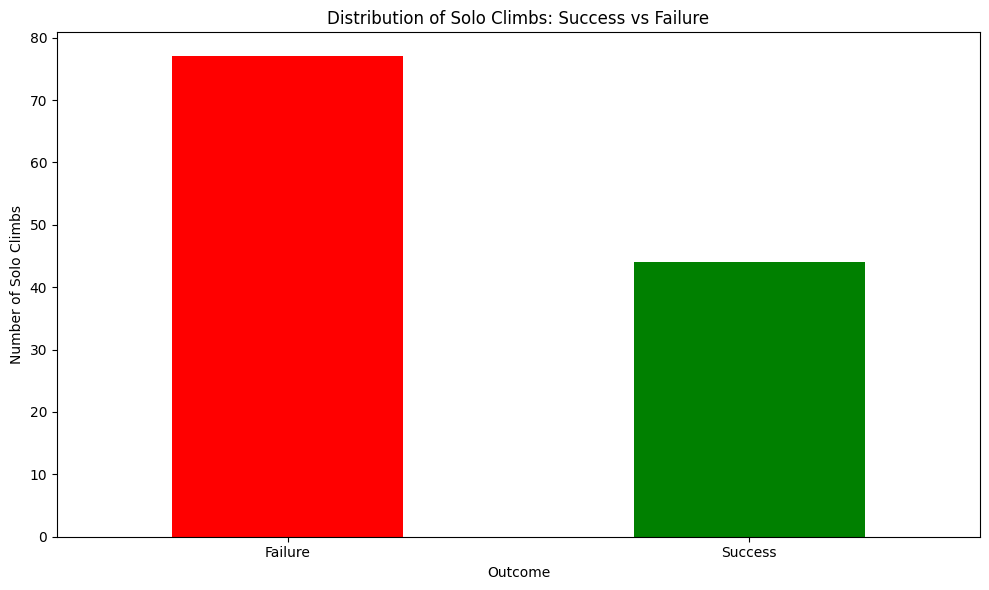

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is called 'df'
# Filter for solo climbs only
solo_df = df[df['solo'] == True]

# Count successes and failures among solo climbs
solo_success_dist = solo_df['success'].value_counts()

# Visualization
plt.figure(figsize=(10, 6))  # Adjust figure size
solo_success_dist.plot(kind='bar', color=['red', 'green'])
plt.title('Distribution of Solo Climbs: Success vs Failure')
plt.xlabel('Outcome')
plt.ylabel('Number of Solo Climbs')
plt.xticks(ticks=[0, 1], labels=['Failure', 'Success'], rotation=0)
plt.tight_layout()
plt.show()


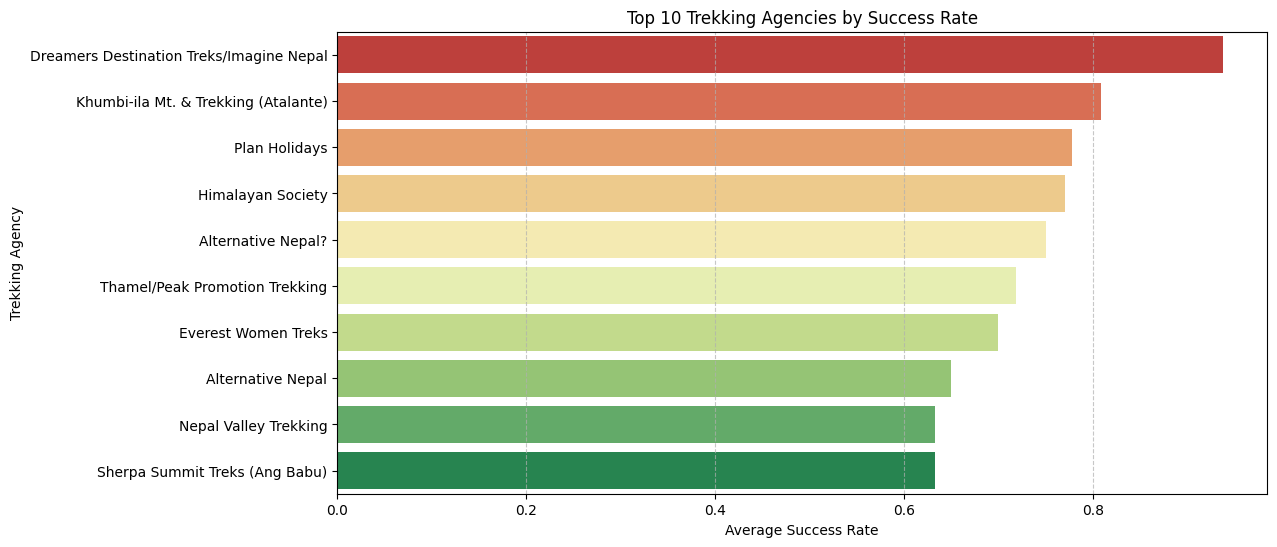

In [79]:
df['peak_success_rate'] = df.groupby('peak_name')['success'].transform(lambda x: x.mean())

# Group by trekking agency and calculate average success rate
agency_success = df.groupby("trekking_agency")["peak_success_rate"].mean().reset_index()

# Sort by success rate in descending order and select the top 10
top_10_agencies = agency_success.sort_values(by="peak_success_rate", ascending=False).head(10)

# Generate a color palette using RdYlGn
colors = sns.color_palette("RdYlGn", n_colors=10)

# Plot the results
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_agencies, x="peak_success_rate", y="trekking_agency", palette=colors)
plt.xlabel("Average Success Rate")
plt.ylabel("Trekking Agency")
plt.title("Top 10 Trekking Agencies by Success Rate")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

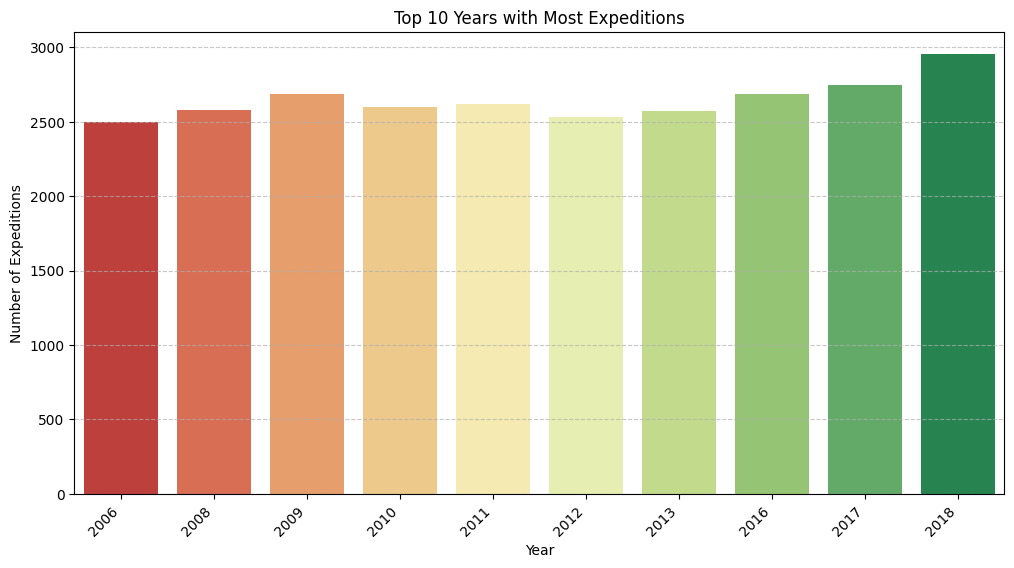

In [80]:
# Group by year and count expeditions
yearly_expeditions = df["year"].value_counts().reset_index()
yearly_expeditions.columns = ["year", "expedition_count"]

# Sort by expedition count in descending order and select the top 10
top_10_years = yearly_expeditions.head(10)

# Generate a color palette using RdYlGn
colors = sns.color_palette("RdYlGn", n_colors=10)

# Plot the results for most climbed expeditions by year
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_years, x="year", y="expedition_count", palette=colors)
plt.xlabel("Year")
plt.ylabel("Number of Expeditions")
plt.title("Top 10 Years with Most Expeditions")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

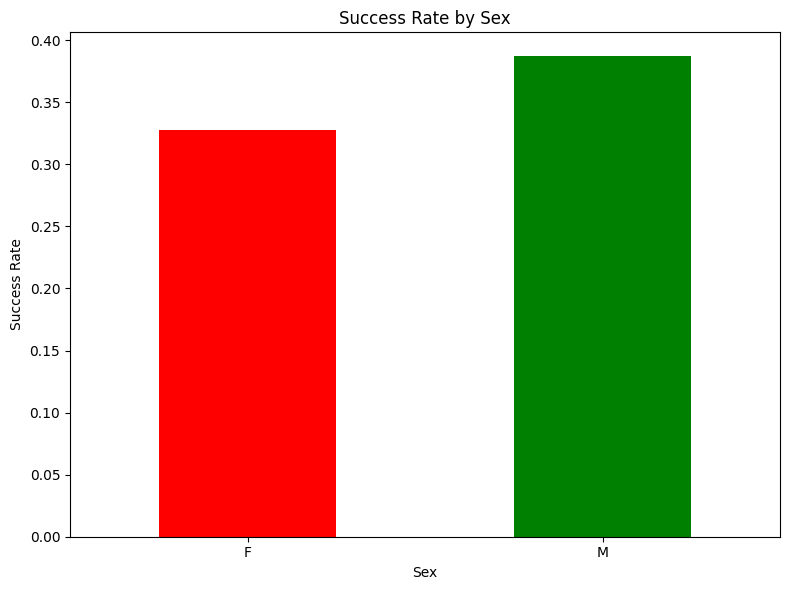

In [81]:
# Success Rate by Sex
plt.figure(figsize=(8, 6))
sex_success = df.groupby('sex')['success'].mean()
sex_success.plot(kind='bar', color=['red', 'green'])
plt.title('Success Rate by Sex')
plt.xlabel('Sex')
plt.ylabel('Success Rate')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


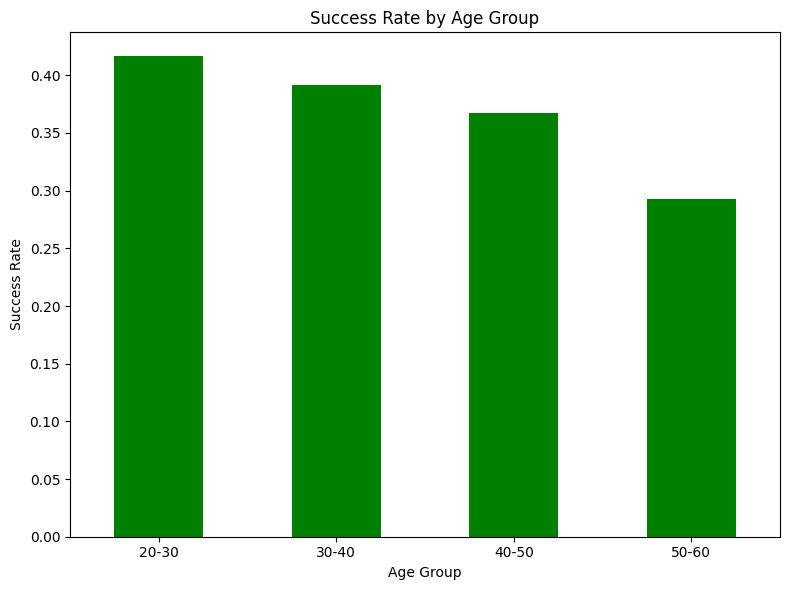

In [82]:
# Success Rate by Age (using age bins)
plt.figure(figsize=(8, 6))
df['age_group'] = pd.cut(df['age'], bins=[20, 30, 40, 50, 60], labels=['20-30', '30-40', '40-50', '50-60'])
age_success = df.groupby('age_group')['success'].mean()
age_success.plot(kind='bar', color='green')
plt.title('Success Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Success Rate')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

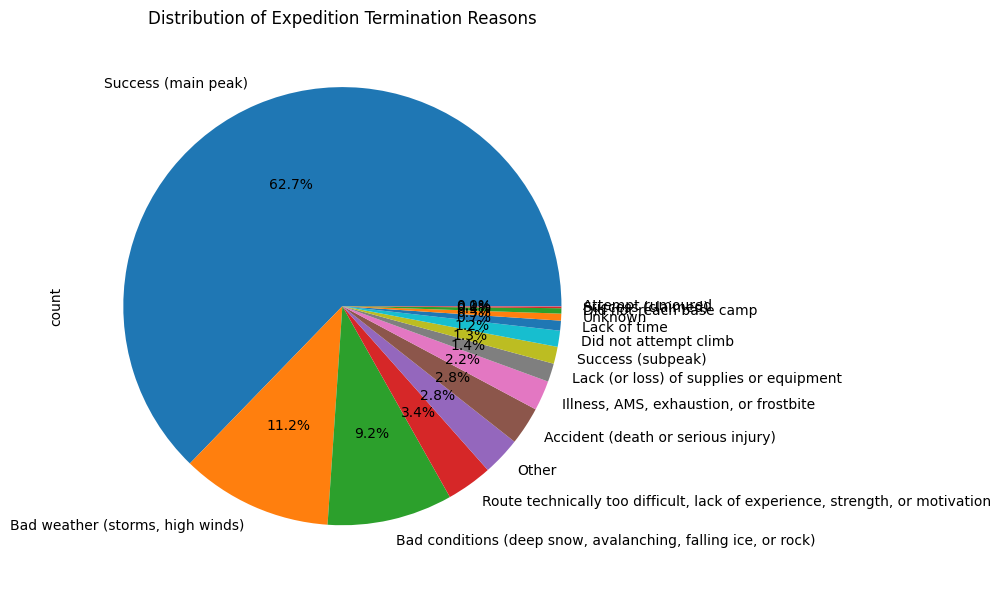

In [83]:
# Main Reason for Expedition Termination
plt.figure(figsize=(10, 6))
termination_counts = df['termination_reason'].value_counts()
termination_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Expedition Termination Reasons')
plt.tight_layout()
plt.show()

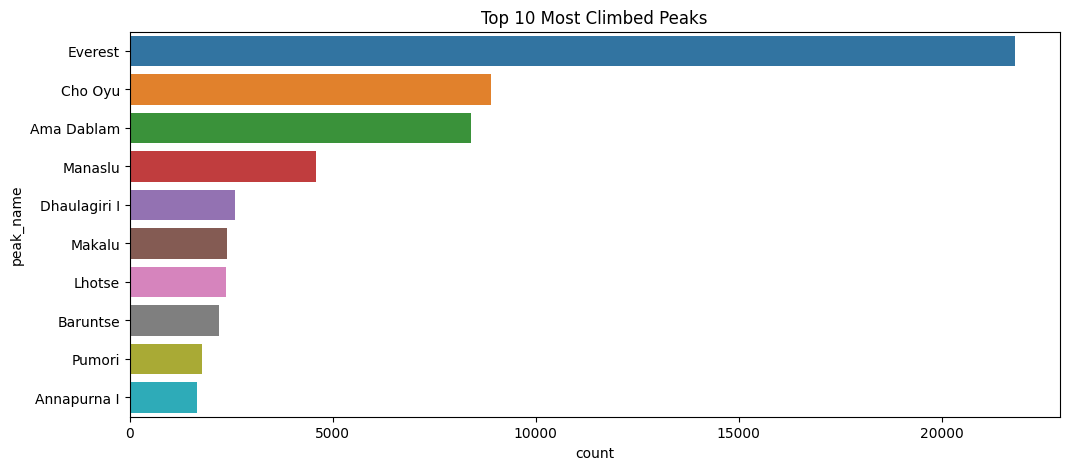

In [84]:
# Top 10 most climbed peaks
plt.figure(figsize=(12, 5))
sns.countplot(data=df, y="peak_name", order=df["peak_name"].value_counts().index[:10])
plt.title("Top 10 Most Climbed Peaks")
plt.show()

## Data Preprocessing and Feature Engineering

In [85]:
# Convert dates to datetime format
df['basecamp_date'] = pd.to_datetime(df['basecamp_date'], errors='coerce')
df['highpoint_date'] = pd.to_datetime(df['highpoint_date'], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76511 entries, 0 to 76510
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   year                76511 non-null  int64         
 1   season              76511 non-null  object        
 2   basecamp_date       76511 non-null  datetime64[ns]
 3   highpoint_date      76511 non-null  datetime64[ns]
 4   termination_reason  76511 non-null  object        
 5   members             76511 non-null  int64         
 6   hired_staff         76511 non-null  int64         
 7   oxygen_used         76511 non-null  bool          
 8   trekking_agency     76511 non-null  object        
 9   height_metres       76511 non-null  int64         
 10  peak_name           76511 non-null  object        
 11  sex                 76511 non-null  object        
 12  age                 76511 non-null  float64       
 13  citizenship         76511 non-null  object    

In [86]:
# Feature Extraction - Date-Based Features
df['expedition_duration'] = (df['highpoint_date'] - df['basecamp_date']).dt.days
df.head()

,year,season,basecamp_date,highpoint_date,termination_reason,members,hired_staff,oxygen_used,trekking_agency,height_metres,peak_name,sex,age,citizenship,expedition_role,success,solo,peak_success_rate,age_group,expedition_duration
0,1960,Spring,1960-03-15,1960-05-17,Success (main peak),10,9,True,Asian Trekking,7937,Annapurna II,M,43.0,UK,Leader,False,False,0.071429,40-50,63
1,1960,Spring,1960-03-15,1960-05-17,Success (main peak),10,9,True,Asian Trekking,7937,Annapurna II,M,32.0,UK,Climber,True,False,0.071429,30-40,63
2,1960,Spring,1960-03-15,1960-05-17,Success (main peak),10,9,True,Asian Trekking,7937,Annapurna II,M,27.0,UK,Climber,False,False,0.071429,20-30,63
3,1960,Spring,1960-03-15,1960-05-17,Success (main peak),10,9,True,Asian Trekking,7937,Annapurna II,M,30.0,UK,Climber,False,False,0.071429,20-30,63
4,1960,Spring,1960-03-15,1960-05-17,Success (main peak),10,9,True,Asian Trekking,7937,Annapurna II,M,25.0,UK,Climber,True,False,0.071429,20-30,63


In [87]:
# Custom mapping for age_group
age_group_mapping = {
    '20-30': 25.0,
    '30-40': 35.0,
    '40-50': 45.0
}

df['age_group'] = df['age_group'].map(age_group_mapping)

In [88]:
# Encode categorical variables
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
for col in cat_cols:
    df[col] = encoder.fit_transform(df[col])

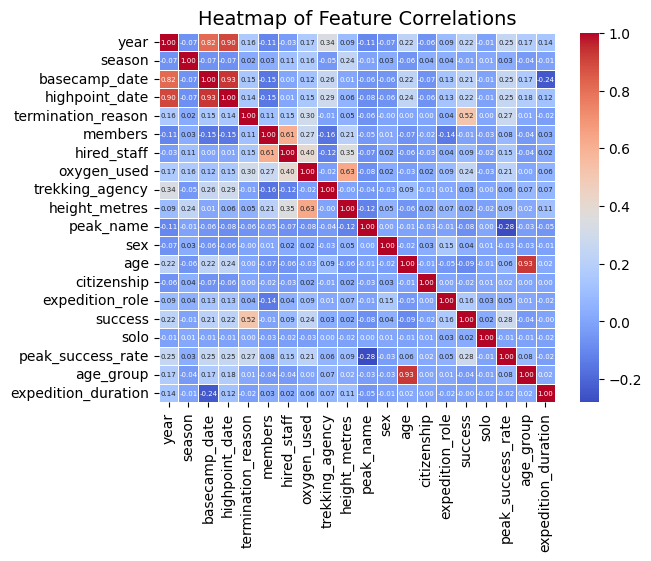

In [89]:
corr = df.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, annot_kws={"size": 5})
plt.title("Heatmap of Feature Correlations", fontsize=14)
plt.show()

In [90]:
drop_cols = ['basecamp_date','highpoint_date','age']
              
df.drop(columns=drop_cols, inplace=True)
df.head()

,year,season,termination_reason,members,hired_staff,oxygen_used,trekking_agency,height_metres,peak_name,sex,citizenship,expedition_role,success,solo,peak_success_rate,age_group,expedition_duration
0,1960,1,12,10,9,True,101,7937,10,1,169,348,False,False,0.071429,45.0,63
1,1960,1,12,10,9,True,101,7937,10,1,169,85,True,False,0.071429,35.0,63
2,1960,1,12,10,9,True,101,7937,10,1,169,85,False,False,0.071429,25.0,63
3,1960,1,12,10,9,True,101,7937,10,1,169,85,False,False,0.071429,25.0,63
4,1960,1,12,10,9,True,101,7937,10,1,169,85,True,False,0.071429,25.0,63


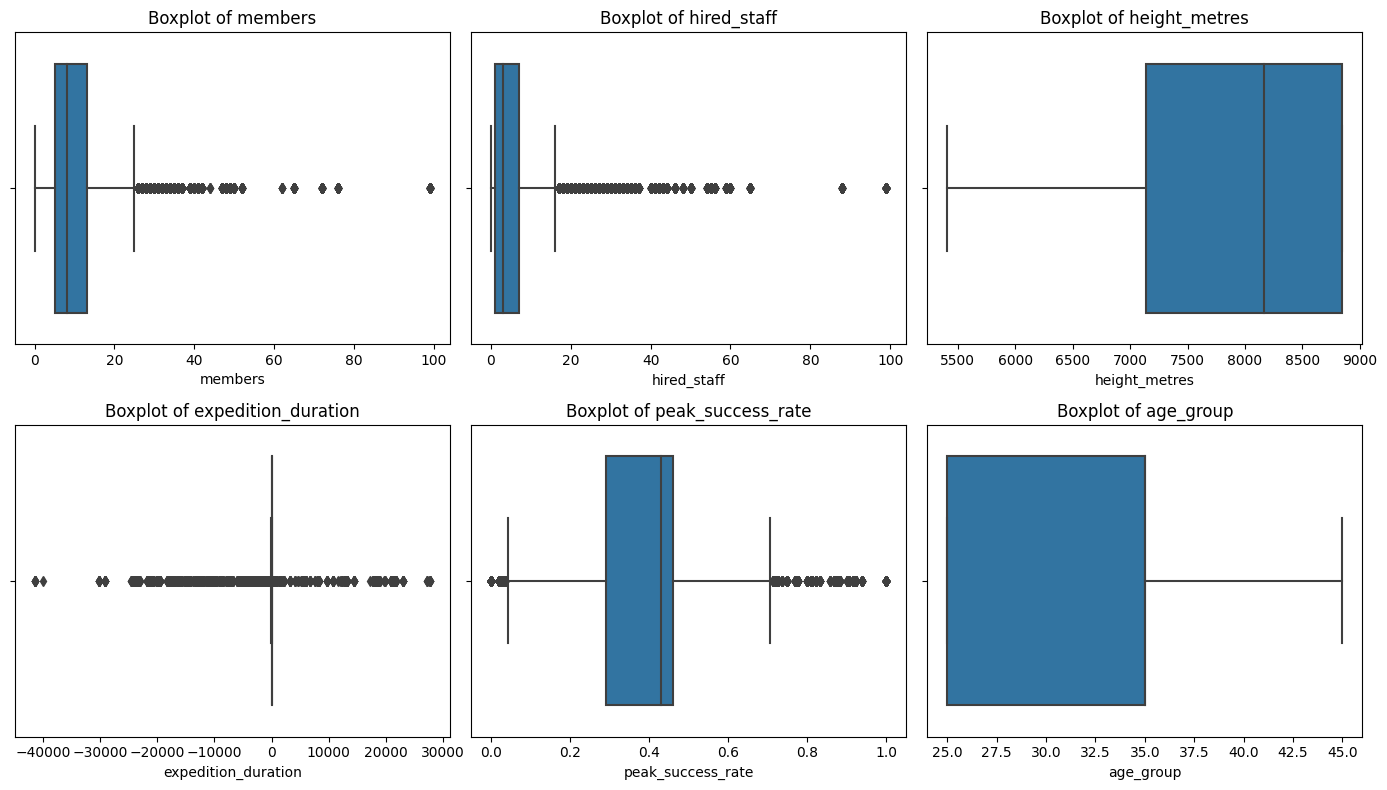

In [91]:
# List of columns to visualize
columns_to_visualize = ['members', 'hired_staff', 'height_metres', 'expedition_duration', 'peak_success_rate', 'age_group']

# Set up the matplotlib figure
plt.figure(figsize=(14, 8))

# Create boxplots for each column
for i, col in enumerate(columns_to_visualize, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

In [92]:
# Function to remove outliers using the IQR method
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# List of columns to check for outliers
columns_to_check = ['members', 'hired_staff', 'height_metres', 'expedition_duration', 'peak_success_rate', 'age_group']

# Remove outliers
df_cleaned = remove_outliers_iqr(df, columns_to_check)

df_cleaned.head()

invalid value encountered in greater_equal
invalid value encountered in less_equal


,year,season,termination_reason,members,hired_staff,oxygen_used,trekking_agency,height_metres,peak_name,sex,citizenship,expedition_role,success,solo,peak_success_rate,age_group,expedition_duration
0,1960,1,12,10,9,True,101,7937,10,1,169,348,False,False,0.071429,45.0,63
1,1960,1,12,10,9,True,101,7937,10,1,169,85,True,False,0.071429,35.0,63
2,1960,1,12,10,9,True,101,7937,10,1,169,85,False,False,0.071429,25.0,63
3,1960,1,12,10,9,True,101,7937,10,1,169,85,False,False,0.071429,25.0,63
4,1960,1,12,10,9,True,101,7937,10,1,169,85,True,False,0.071429,25.0,63


In [93]:
# Calculate success rate
success_rate = df_cleaned['success'].mean() * 100
print(f"\nOverall Expedition Success Rate: {success_rate:.2f}%")


Overall Expedition Success Rate: 38.29%


### Model Development and Evaluation

In [94]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_score, confusion_matrix, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay
import optuna
import time

# Define features and target
X = df.drop(columns=['success'])
y = df['success']

# Handle missing values using mean imputation
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Base Model Comparison
### Comparing 10 different ML algorithms to establish baseline performance


In [95]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM": SVC(),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "Ada Boost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier(),
    "CatBoost": CatBoostClassifier()
}

# Iterate through each model, fit, and evaluate
for model_name, model in models.items():
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Training set performance
    model_train_accuracy = accuracy_score(y_train, y_train_pred)
    model_train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    model_train_precision = precision_score(y_train, y_train_pred)
    model_train_recall = recall_score(y_train, y_train_pred)
    model_train_rocauc_score = roc_auc_score(y_train, y_train_pred)

    # Test set performance
    model_test_accuracy = accuracy_score(y_test, y_test_pred)
    model_test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    model_test_precision = precision_score(y_test, y_test_pred)
    model_test_recall = recall_score(y_test, y_test_pred)
    model_test_rocauc_score = roc_auc_score(y_test, y_test_pred)
    
    # Print results
    print(model_name)
    print('Model Performance for Training set')
    print("- Accuracy : {:.4f}".format(model_train_accuracy))
    print('- F1 Score: {:.4f}'.format(model_train_f1))
    print('- Precision: {:.4f}'.format(model_train_precision))
    print('- Recall: {:.4f}'.format(model_train_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))
    
    print('-------------------------------------')
    
    print('Model Performance for Test set')
    print("- Accuracy : {:.4f}".format(model_test_accuracy))
    print('- F1 Score: {:.4f}'.format(model_test_f1))
    print('- Precision: {:.4f}'.format(model_test_precision))
    print('- Recall: {:.4f}'.format(model_test_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
    print('\n')


Logistic Regression
Model Performance for Training set
- Accuracy : 0.7749
- F1 Score: 0.7772
- Precision: 0.6804
- Recall: 0.7731
- Roc Auc Score: 0.7746
-------------------------------------
Model Performance for Test set
- Accuracy : 0.7772
- F1 Score: 0.7794
- Precision: 0.6838
- Recall: 0.7741
- Roc Auc Score: 0.7766


Random Forest
Model Performance for Training set
- Accuracy : 0.9528
- F1 Score: 0.9528
- Precision: 0.9383
- Recall: 0.9379
- Roc Auc Score: 0.9499
-------------------------------------
Model Performance for Test set
- Accuracy : 0.8324
- F1 Score: 0.8328
- Precision: 0.7731
- Recall: 0.7936
- Roc Auc Score: 0.8250


Gradient Boosting
Model Performance for Training set
- Accuracy : 0.8220
- F1 Score: 0.8232
- Precision: 0.7449
- Recall: 0.8110
- Roc Auc Score: 0.8199
-------------------------------------
Model Performance for Test set
- Accuracy : 0.8223
- F1 Score: 0.8237
- Precision: 0.7438
- Recall: 0.8150
- Roc Auc Score: 0.8209


Decision Tree
Model Performanc

## Hyperparameter Tuning with Optuna
### Optimizing CatBoost using Bayesian optimization

In [96]:
# # Define the objective function for Optuna with expanded search space
# def objective(trial):
#     params = {
#         "iterations": trial.suggest_int("iterations", 100, 1500, step=50),  # Expanded range
#         "depth": trial.suggest_int("depth", 3, 12),  # Wider depth range
#         "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.5),  # Wider learning rate
#         "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-4, 20.0),  # More regularization options
#         "border_count": trial.suggest_int("border_count", 16, 300),  # Expanded border count
#         "random_strength": trial.suggest_uniform("random_strength", 0.05, 15.0),  # Wider random strength
#         "bagging_temperature": trial.suggest_uniform("bagging_temperature", 0.0, 2.0),  # Wider bagging temp
#         "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
#         "od_wait": trial.suggest_int("od_wait", 5, 100),  # Wider overfit detection wait
#         "colsample_bylevel": trial.suggest_uniform("colsample_bylevel", 0.5, 1.0),  # Added feature sampling
#     }
    
#     # Initialize CatBoost model
#     model = CatBoostClassifier(**params, random_state=42, silent=True)
    
#     # Perform cross-validation
#     cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    
#     return np.mean(cv_scores)  # Optimize for highest accuracy

# # Timing the hyperparameter tuning process
# start_time = time.time()

# # Create a study object and optimize
# study = optuna.create_study(direction="maximize")  # Maximize accuracy
# study.optimize(objective, n_trials=10, n_jobs=-1)  # Run 50 trials with parallel processing

# # Calculate tuning duration
# tuning_duration = time.time() - start_time

# # Print tuning results
# print("\n=== Hyperparameter Tuning Results ===")
# print(f"Number of Trials: {len(study.trials)}")
# print(f"Best Trial: {study.best_trial.number}")
# print(f"Best Hyperparameters: {study.best_params}")
# print(f"Best Cross-Validation Accuracy: {study.best_value:.4f}")
# print(f"Tuning Duration: {tuning_duration:.2f} seconds")

# # Train CatBoost with the best parameters and time it
# start_training_time = time.time()

# best_params = study.best_params
# best_model = CatBoostClassifier(**best_params, random_state=42, silent=True)
# best_model.fit(X_train, y_train)

# training_duration = time.time() - start_training_time
# print(f"\nTraining Duration with Best Parameters: {training_duration:.2f} seconds")

# # Evaluate on the test set
# y_pred = best_model.predict(X_test)
# y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probability for ROC AUC

# # Calculate evaluation metrics
# test_accuracy = accuracy_score(y_test, y_pred)
# test_f1 = f1_score(y_test, y_pred, average='weighted')
# test_precision = precision_score(y_test, y_pred)
# test_recall = recall_score(y_test, y_pred)
# test_roc_auc = roc_auc_score(y_test, y_pred_proba)

# # Print evaluation results
# print("\n=== Best Model Performance on Test Set ===")
# print(f"Test Accuracy: {test_accuracy:.4f}")
# print(f"F1 Score: {test_f1:.4f}")
# print(f"Precision: {test_precision:.4f}")
# print(f"Recall: {test_recall:.4f}")
# print(f"ROC AUC Score: {test_roc_auc:.4f}")
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))

# # Confusion Matrix Visualization
# plt.figure(figsize=(6, 4))
# sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
# plt.title("Confusion Matrix - Best CatBoost Model")
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.show()

# # Feature Importance Visualization
# feature_importance = pd.DataFrame({
#     'Feature': df.drop(columns=['success']).columns,
#     'Importance': best_model.feature_importances_
# })
# feature_importance = feature_importance.sort_values('Importance', ascending=False)

# plt.figure(figsize=(10, 6))
# sns.barplot(data=feature_importance, x='Importance', y='Feature', palette='viridis')
# plt.title("Feature Importance - Best CatBoost Model")
# plt.show()

# # Store the best model and its metrics
# best_model_info = {
#     "model": best_model,
#     "hyperparameters": best_params,
#     "test_accuracy": test_accuracy,
#     "test_f1": test_f1,
#     "test_precision": test_precision,
#     "test_recall": test_recall,
#     "test_roc_auc": test_roc_auc,
#     "tuning_duration": tuning_duration,
#     "training_duration": training_duration
# }

# print("\n=== Best Model Summary ===")
# for key, value in best_model_info.items():
#     if key != "model":
#         print(f"{key}: {value}")

[I 2025-02-22 16:50:28,048] A new study created in memory with name: no-name-e2824b27-e9b1-4b86-ab99-3f63759ea26c
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float


=== Hyperparameter Tuning Results ===
Number of Trials: 10
Best Trial: 3
Best Hyperparameters: {'iterations': 500, 'depth': 8, 'learning_rate': 0.11022587427628452, 'l2_leaf_reg': 0.003937980768680974, 'border_count': 157, 'random_strength': 6.248348329757198, 'bagging_temperature': 0.7206849752527333, 'od_type': 'Iter', 'od_wait': 27, 'colsample_bylevel': 0.6956154300746376}
Best Cross-Validation Accuracy: 0.8350
Tuning Duration: 752.43 seconds

Training Duration with Best Parameters: 7.22 seconds

=== Best Model Performance on Test Set ===
Test Accuracy: 0.8443
F1 Score: 0.7999
Precision: 0.7846
Recall: 0.8157
ROC AUC Score: 0.9273

Classification Report:
              precision    recall  f1-score   support

       False       0.88      0.86      0.87      9465
        True       0.78      0.82      0.80      5838

    accuracy                           0.84     15303
   macro avg       0.83      0.84      0.84     15303
weighted avg       0.85      0.84      0.84     15303



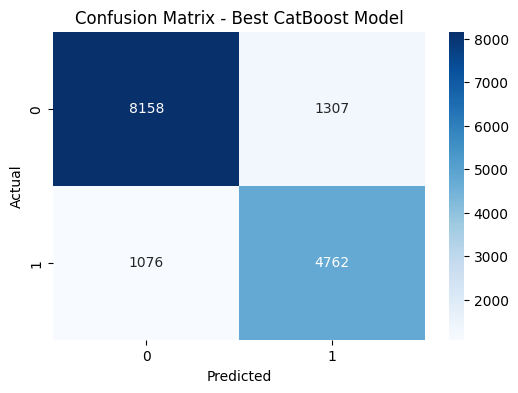

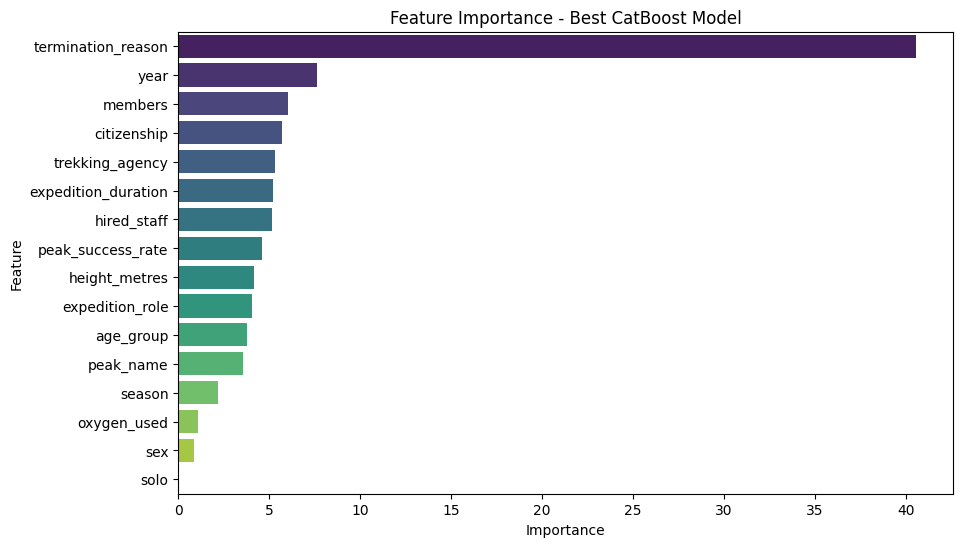


=== Best Model Summary ===
hyperparameters: {'iterations': 500, 'depth': 8, 'learning_rate': 0.11022587427628452, 'l2_leaf_reg': 0.003937980768680974, 'border_count': 157, 'random_strength': 6.248348329757198, 'bagging_temperature': 0.7206849752527333, 'od_type': 'Iter', 'od_wait': 27, 'colsample_bylevel': 0.6956154300746376}
test_accuracy: 0.8442788995621774
test_f1: 0.7998656252624506
test_precision: 0.7846432690723348
test_recall: 0.815690304898938
test_roc_auc: 0.9273366093179339
tuning_duration: 752.4331223964691
training_duration: 7.221702814102173


In [97]:
import numpy as np
import pandas as pd
import time
import optuna
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Define the objective function for Optuna with expanded search space
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1500, step=50),
        "depth": trial.suggest_int("depth", 3, 12),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.5),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-4, 20.0),
        "border_count": trial.suggest_int("border_count", 16, 300),
        "random_strength": trial.suggest_uniform("random_strength", 0.05, 15.0),
        "bagging_temperature": trial.suggest_uniform("bagging_temperature", 0.0, 2.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 5, 100),
        "colsample_bylevel": trial.suggest_uniform("colsample_bylevel", 0.5, 1.0),
    }
    
    # Initialize CatBoost model
    model = CatBoostClassifier(**params, random_state=42, silent=True)
    
    # Define Stratified K-Fold cross-validator
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Perform cross-validation with StratifiedKFold
    cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)
    
    return np.mean(cv_scores)  # Optimize for highest accuracy

# Timing the hyperparameter tuning process
start_time = time.time()

# Create a study object and optimize
study = optuna.create_study(direction="maximize")  # Maximize accuracy
study.optimize(objective, n_trials=10, n_jobs=-1)  # Run 10 trials with parallel processing (note: comment says 50, but code uses 10)

# Calculate tuning duration
tuning_duration = time.time() - start_time

# Print tuning results
print("\n=== Hyperparameter Tuning Results ===")
print(f"Number of Trials: {len(study.trials)}")
print(f"Best Trial: {study.best_trial.number}")
print(f"Best Hyperparameters: {study.best_params}")
print(f"Best Cross-Validation Accuracy: {study.best_value:.4f}")
print(f"Tuning Duration: {tuning_duration:.2f} seconds")

# Train CatBoost with the best parameters and time it
start_training_time = time.time()

best_params = study.best_params
best_model = CatBoostClassifier(**best_params, random_state=42, silent=True)
best_model.fit(X_train, y_train)

training_duration = time.time() - start_training_time
print(f"\nTraining Duration with Best Parameters: {training_duration:.2f} seconds")

# Evaluate on the test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probability for ROC AUC

# Calculate evaluation metrics (adjusted for binary classification)
test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)  # Removed 'average' since it's binary
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print evaluation results
print("\n=== Best Model Performance on Test Set ===")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"ROC AUC Score: {test_roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix Visualization
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Best CatBoost Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature Importance Visualization
# Use the feature names from the original DataFrame (excluding the target 'success')
feature_importance = pd.DataFrame({
    'Feature': df.drop(columns=['success']).columns,
    'Importance': best_model.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature', palette='viridis')
plt.title("Feature Importance - Best CatBoost Model")
plt.show()

# Store the best model and its metrics
best_model_info = {
    "model": best_model,
    "hyperparameters": best_params,
    "test_accuracy": test_accuracy,
    "test_f1": test_f1,
    "test_precision": test_precision,
    "test_recall": test_recall,
    "test_roc_auc": test_roc_auc,
    "tuning_duration": tuning_duration,
    "training_duration": training_duration
}

print("\n=== Best Model Summary ===")
for key, value in best_model_info.items():
    if key != "model":
        print(f"{key}: {value}")

## Model Interpretation
### Explainability using SHAP values

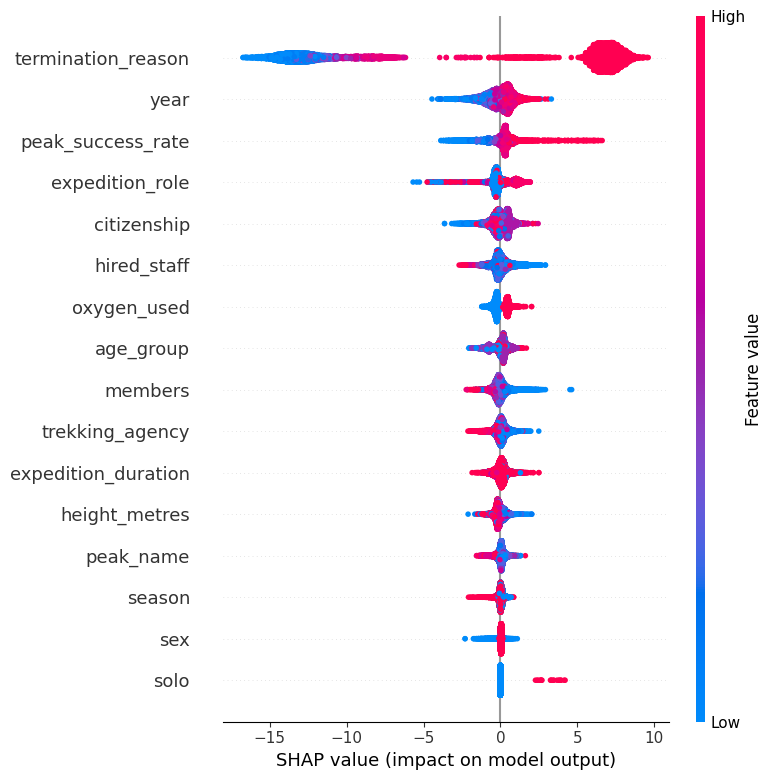

Top Feature: termination_reason


In [98]:
# After training the best model
import shap

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, feature_names=df.drop(columns=['success']).columns)
plt.show()

# Update best_model_info with top feature
best_model_info['top_feature'] = feature_importance['Feature'].iloc[0]
print(f"Top Feature: {best_model_info['top_feature']}")

<Figure size 1000x600 with 0 Axes>

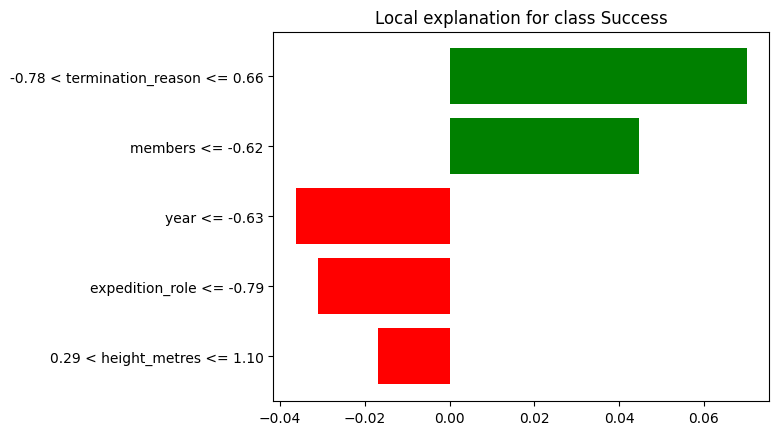

In [101]:
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

# Create a LIME explainer
explainer = LimeTabularExplainer(
    X_train,
    feature_names=df.drop(columns=['success']).columns,
    class_names=['Failure', 'Success'],
    mode='classification'
)

# Explain a single prediction (first test instance)
exp = explainer.explain_instance(X_test[0], best_model.predict_proba, num_features=5)

# Visualize (use one of these depending on your environment)
exp.show_in_notebook()  # For Jupyter notebooks
# Or for non-notebook environments:
plt.figure(figsize=(10, 6))
exp.as_pyplot_figure()
plt.show()

In [102]:
# Save the trained model
import joblib
joblib.dump(best_model_info, 'best.sav')


['best.sav']